# GeoPhy Callenge - Choice 1 - Stergios Koutrouvelis

Import necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Load the two datasets:

In [2]:
train = pd.read_csv('train.csv',low_memory=False)
test = pd.read_csv('test.csv', low_memory=False)

In [3]:
print('Train dataset:')
display(train.head())
print('\n')
print('Test dataset:')
display(test.head())

Train dataset:


,index,borough,block,lot,schooldist,council,zipcode,firecomp,policeprct,healthcenterdistrict,...,yearalter1,yearalter2,histdist,landmark,builtfar,tract2010,xcoord,ycoord,zonemap,target__office
0,574546,BX,3717,64,8.0,18.0,10472.0,E096,43.0,26.0,...,0,0,NaN,NaN,0.62,48,1018914.0,239801.0,6C,False
1,12600,QN,15818,48,27.0,31.0,11691.0,E264,101.0,45.0,...,0,0,NaN,NaN,0.48,99802,1051073.0,155952.0,31A,False
2,235922,BK,6787,7,22.0,48.0,11229.0,E276,61.0,35.0,...,0,0,NaN,NaN,0.69,548,998378.0,161944.0,23B,False
3,202581,BK,672,30,15.0,38.0,11232.0,E228,72.0,39.0,...,0,0,NaN,NaN,1.24,101,983777.0,178952.0,16B,False
4,155971,BK,6651,7501,21.0,44.0,11223.0,E330,62.0,37.0,...,0,0,NaN,NaN,3.59,426,990141.0,159965.0,22D,False




Test dataset:


,index,borough,block,lot,schooldist,council,zipcode,firecomp,policeprct,healthcenterdistrict,...,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,tract2010,xcoord,ycoord,zonemap
0,432027,BK,3361,34,32.0,37.0,11221.0,L112,83.0,34.0,...,1931,2015,0,NaN,NaN,1.94,435,1008377.0,192685.0,13B
1,97433,QN,654,17,30.0,22.0,11103.0,L117,114.0,41.0,...,1931,0,0,NaN,NaN,1.34,143,1008289.0,218741.0,9A
2,408327,QN,3811,12,24.0,30.0,11385.0,E319,104.0,46.0,...,1925,0,0,NaN,NaN,0.67,63301,1018637.0,196297.0,13D
3,365188,QN,10988,17,29.0,27.0,11412.0,L150,113.0,44.0,...,1920,0,0,NaN,NaN,0.61,526,1050330.0,193922.0,15B
4,856787,BK,2619,36,14.0,33.0,11222.0,L106,94.0,30.0,...,1899,0,0,NaN,NaN,1.72,561,997418.0,203572.0,13A


As part of our exploratory data analysis, we plot the datapoints based on the coordinates and seperated by the response variable.

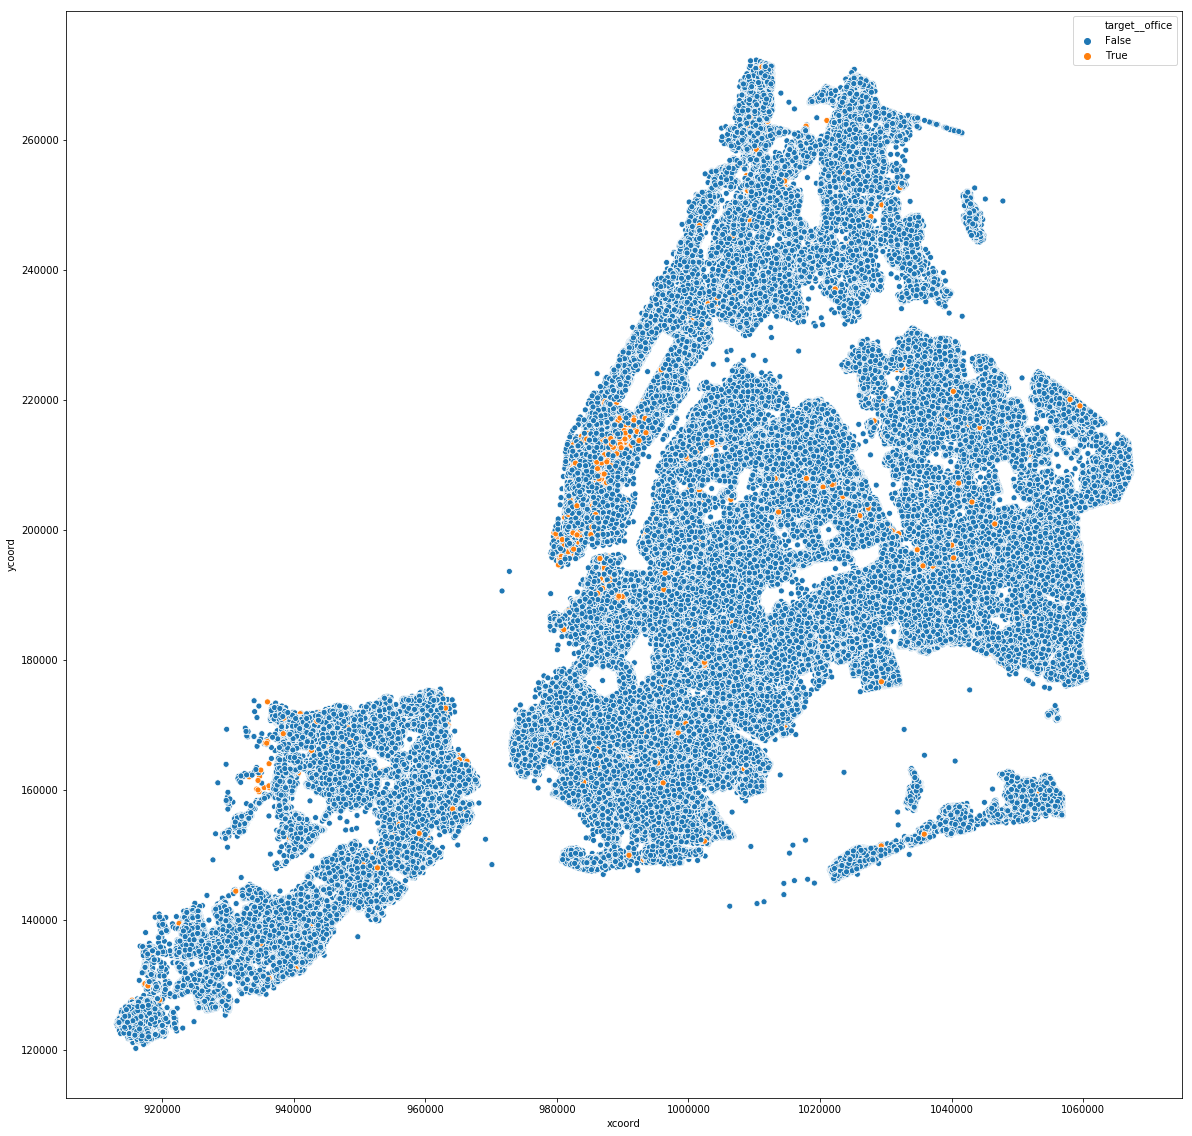

In [4]:
plt.figure(figsize=(20,20))
sns.scatterplot('xcoord','ycoord',data=train,hue='target__office')

From this plot we observe that we are dealing with a heavily imbalanced dataset.

### Imputation of Missing Values and Preprocessing of the datasets

Starting with the train dataset, we will plot a heatmap in order to get a "birdseye" view of the data and see the scale of missing values:

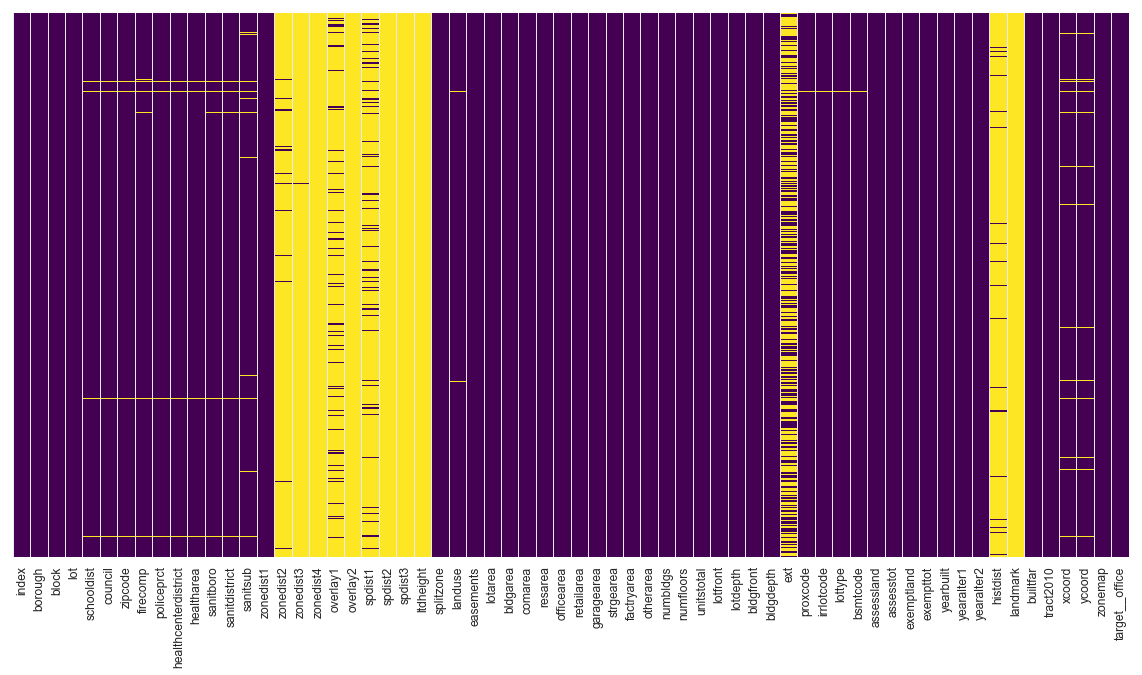

In [5]:
plt.figure(figsize=(20,10))
sns.set_style('whitegrid')
sns.set(font_scale=1.1)
sns.heatmap(data=train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

We observe that there are a few columns where most values are missing. 
<br>
<br>
Next we define a function that will process both our datasets. The function will take each dataset as an input, process every column based on the type and an evaluation from the supporting document. The function performs one-hot-encoding for categorical variables, modifies some numeric variables for model predictions, imputes missing values and identifies potential outliers.

In [6]:
def clean(df):
    
    from functools import reduce
    
    to_merge = []
    
    '''borough: one-hot-encoding for each building and each borough'''
    
    borough = df[['index','borough']].copy()
    boroughs = borough.borough.unique().tolist()
    for b in boroughs:
        borough['borough_'+b] = borough.borough.str.contains(b).astype(int)
    del borough['borough']
    to_merge.append(borough)

    
    '''firecomp: one-hot-encoding where
       E stands for Engine, 
       L stands for Ladder, 
       Q stands for Squad and 
       M for missing value'''
    
    firecomp = df[['index','firecomp']].copy()
    firecomp.firecomp = firecomp.firecomp.fillna('Missing')
    unique_firecomp = set([f[0] for f in firecomp.firecomp.unique()])
    for f in unique_firecomp:
        firecomp['fire_com_'+ f] = firecomp.firecomp.apply(lambda x: int(x.startswith(f)))
    del firecomp['firecomp']
    to_merge.append(firecomp)
    
    
    '''zonedist1: one-hot-encoding for each type of district or district missing'''
    
    zonedist1 = df[['index','zonedist1']].copy()
    zonedist1.zonedist1 = zonedist1.zonedist1.fillna('Missing')
    
    import re

    def man_and_res(x):
        return bool(re.search(r'^M[0-9\-]{1,3}\/R[0-9A-Z\-]{1,5}$', x))

    def res(x):
        return bool(re.search(r'^R[0-9A-Z\-]{1,4}$',x))
    
    def com(x):
        return bool(re.search(r'^C[0-9A-Z\-\.]{1,5}$',x))
    
    def man(x):
        return bool(re.search(r'^M[0-9A-Z\-]{1,4}$',x))
    
    zonedist1['res'] = zonedist1.zonedist1.apply(lambda x: int(res(x)))
    zonedist1['man'] = zonedist1.zonedist1.apply(lambda x: int(man(x)))
    zonedist1['comm'] = zonedist1.zonedist1.apply(lambda x: int(com(x)))
    zonedist1['man_and_res'] = zonedist1.zonedist1.apply(lambda x: int(man_and_res(x)))
    zonedist1['bpc'] = zonedist1.zonedist1.apply(lambda x: int(x == 'BPC'))
    zonedist1['park'] = zonedist1.zonedist1.apply(lambda x: int(x == 'PARK'))
    zonedist1['dist_missing'] = zonedist1.zonedist1.apply(lambda x: int(x == 'Missing'))
    del zonedist1['zonedist1']
    to_merge.append(zonedist1)
    
    
    '''zonedist2-4: most of the column is null. Will keep a boolean inidicating null or not'''
    
    zonedist2_4 = df[['index','zonedist2','zonedist3','zonedist4']].copy()
    zonedist2_4['zonedist2'] = zonedist2_4.zonedist2.notnull().astype(int)
    zonedist2_4['zonedist3'] = zonedist2_4.zonedist3.notnull().astype(int)
    zonedist2_4['zonedist4'] = zonedist2_4.zonedist4.notnull().astype(int)
    to_merge.append(zonedist2_4)
    
    
    '''overlay1_2: most of these columns is null. Will keep a boolean indicating null or not'''
    
    overlay1_2 = df[['index','overlay1','overlay2']].copy()
    overlay1_2['overlay1'] = overlay1_2.overlay1.notnull().astype(int)
    overlay1_2['overlay2'] = overlay1_2.overlay2.notnull().astype(int)
    to_merge.append(overlay1_2)
    
    
    '''spdist1_3: most of the columns is null. Will keep a boolean indicating null or not
       except for spdist3 which we will not include since all values are null'''
    
    spdist1_2 = df[['index','spdist1','spdist2']].copy()
    spdist1_2['spdist1'] = spdist1_2.spdist1.notnull().astype(int)
    spdist1_2['spdist2'] = spdist1_2.spdist2.notnull().astype(int)
    to_merge.append(spdist1_2)
    
    
    '''ltdheight: boolean to indicate if the building is assigned to limited height district or not'''
    
    ltdheight = df[['index', 'ltdheight']].copy()
    ltdheight['ltdheight'] = ltdheight.ltdheight.notnull().astype(int)
    to_merge.append(ltdheight)    
    
    
    '''splitzone: Y or N values and some missing values.
       According to the dictionary from PLUTO, the splitzone is Y if the building has a value for:
       ZONING DISTRICT 2, COMMERCIAL OVERLAY 2, or SPECIAL DISTRICT BOUNDARY 2.
       So we can impute the missing values based on this information. The rest will be booleans'''
    
    splitzone = df[['index', 'splitzone']].copy()
    splitzone = splitzone.merge(df[['index','zonedist2','overlay2','spdist2']].copy(), on='index', how='outer')
    
    def split(x):
        if x.splitzone=='Y':
            return 1
        elif x.splitzone=='N':
            return 0
        elif pd.isna(x.splitzone):
            return int(pd.notna(x.zonedist2) | pd.notna(x.overlay2) | pd.notna(x.spdist2))
    
    splitzone['splitzone'] = splitzone.apply(lambda x: split(x), axis=1)
    to_merge.append(splitzone[['index','splitzone']])
    
    
    '''landuse: One-hot-encoding for each category'''
    
    landuse = df[['index','landuse']].copy()
    use = landuse[landuse.landuse.notnull()].landuse.unique().tolist()
    landuse.landuse = landuse.landuse.fillna('Missing')
    for u in use:
        landuse['landuse_'+str(int(u))] = landuse.landuse.apply(lambda x: int(x==u))
    landuse['landuse_missing'] = landuse.landuse.apply(lambda x: int(x=='Missing'))
    del landuse['landuse']
    to_merge.append(landuse)
    
    
    '''easements: not missing values and variable is numeric'''
    to_merge.append(df[['index','easements']].copy())
    
    
    # The next variables from "lotarea" to "bldgdepth" are all numeric and will process them together.
    # Impute missing values with mean.
    
    '''First work with columns representing area'''
    
    area_cols = [col for col in df.loc[:,'lotarea':] if col.endswith('area')]
    areas = df[['index'] + area_cols].copy()
    for area in area_cols:
        areas.loc[:,area].fillna(areas[area].mean(),inplace=True)
    
    to_merge.append(areas)
    
    
    '''numbldgs, numfloors, unitstotal'''
    bfu = df[['index', 'numbldgs', 'numfloors', 'unitstotal']].copy()
    for col in bfu.columns[1:]:
        bfu.loc[:,col].fillna(bfu[col].mean(),inplace=True)
    
    to_merge.append(bfu)
    
    
    '''lotfront, lotdepth, bldgfront, bldgdepth'''
    llbb = df[['index', 'lotfront', 'lotdepth', 'bldgfront', 'bldgdepth']].copy()
    for col in llbb.columns[1:]:
        llbb.loc[:,col].fillna(llbb[col].mean(),inplace=True)
    
    to_merge.append(llbb)    
    
    
    '''ext: extension code will be processed with one-hot-encoding for:
       E: Extension
       G: Garage
       EG: Extension and Garage
       M: Missing'''
    
    ext = df[['index','ext']].copy()
    ext.ext.fillna('M', inplace=True)
    uniq_ext = ext.ext.unique().tolist()
    for e in uniq_ext:
        ext['ext_' + e] = ext.ext.apply(lambda x: int(x==e))
    del ext['ext']
    
    to_merge.append(ext)
    
    
    '''proxcode: proximity code will be processed with one-hot-encoding for:
       0: Not Available
       1: Detached
       2: Semi-attached
       3: Attached
       4: Missing'''
    
    proxcode = df[['index','proxcode']].copy()
    proxcode.proxcode.fillna('M',inplace=True)
    up = proxcode.proxcode.unique().tolist()
    for p in up:
        proxcode['prcd_' + str(p)] = proxcode.proxcode.apply(lambda x: int(x==p))
    del proxcode['proxcode']
    to_merge.append(proxcode)
    
    
    '''irrlotcode: will have binary values 1 for Y, 0 for N and missing values'''
    irrlotcode = df[['index', 'irrlotcode']].copy()
    irrlotcode.irrlotcode = irrlotcode.irrlotcode.apply(lambda x: int(x=='Y'))
    to_merge.append(irrlotcode)
    
    
    '''assessland, assesstot, exemptland, exempttot'''    
    aaee = df[['index', 'assessland', 'assesstot', 'exemptland', 'exempttot']].copy()
    for col in aaee.columns[1:]:
        aaee.loc[:,col].fillna(aaee[col].mean(),inplace=True)
    to_merge.append(aaee)
    
    
    '''yearbuilt: will replace entries that have zero values with the mean yearbuilt'''
    yearbuilt = df[['index','yearbuilt']].copy()
    mean = yearbuilt[yearbuilt.yearbuilt!=0].yearbuilt.mean()
    yearbuilt.yearbuilt.fillna(mean, inplace=True)
    yearbuilt.loc[yearbuilt.yearbuilt==0,'yearbuilt'] = int(mean)
    to_merge.append(yearbuilt)
    
    
    '''yearalter1, yearalter2: will introduce boolean values indicating whether the building has been altered
       once or twice'''
    yearalter = df[['index', 'yearalter1', 'yearalter2']].copy()
    yearalter['yearalter1'] = yearalter.yearalter1.apply(lambda x: int(x!=0))
    yearalter['yearalter2'] = yearalter.yearalter2.apply(lambda x: int(x!=0))
    to_merge.append(yearalter)
    
    
    '''histdist, landmark: will introduce booleans'''
    hl = df[['index', 'histdist', 'landmark']].copy()
    hl['histdist'] = hl.histdist.apply(lambda x: int(pd.notna(x)))
    hl['landmark'] = hl.landmark.apply(lambda x: int(pd.notna(x)))
    to_merge.append(hl)
    
    '''builtfar: will replace missing values with the mean'''
    builtfar = df[['index', 'builtfar']].copy()
    builtfar.builtfar.fillna(builtfar[builtfar.builtfar.notna()].builtfar.mean(), inplace=True)
    to_merge.append(builtfar)
    
    
    '''xcoord, ycoord: will impute missing values based on averate coordinates by zipcodes'''
    coords = df[['index','zipcode','xcoord','ycoord']].copy()
    coords['zipcode'].fillna(0,inplace=True)
    pred_coord = coords.groupby(by='zipcode').mean()
    pred_coord.xcoord.fillna(np.mean(coords.xcoord), inplace=True)
    pred_coord.ycoord.fillna(np.mean(coords.ycoord), inplace=True)
    coords.loc[coords.xcoord.isnull(), 'xcoord'] = coords[coords.xcoord.isnull()].apply(lambda x: pred_coord.loc[x['zipcode'], 'xcoord'], axis=1)
    coords.loc[coords.ycoord.isnull(), 'ycoord'] = coords[coords.ycoord.isnull()].apply(lambda x: pred_coord.loc[x['zipcode'], 'ycoord'], axis=1)
    
    
    to_merge.append(coords[['index','xcoord','ycoord']])
    
    
    
    if 'target__office' in df.columns:
        to_merge.append(df[['index','target__office']].copy())
    
    final = reduce(lambda x, y: pd.merge(x, y, on = 'index', how='outer'), to_merge)
    #final = final[final.notnull().all(axis=1)]
    return final

Using the function that we defined, we process our training dataset in order to fit our classifier:

In [7]:
train_clean = clean(train)
display(train_clean.head())

,index,borough_BX,borough_QN,borough_BK,borough_MN,borough_SI,fire_com_M,fire_com_L,fire_com_E,fire_com_Q,...,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,xcoord,ycoord,target__office
0,574546,1,0,0,0,0,0,0,1,0,...,0,1940,0,0,0,0,0.62,1018914.0,239801.0,False
1,12600,0,1,0,0,0,0,0,1,0,...,0,1930,0,0,0,0,0.48,1051073.0,155952.0,False
2,235922,0,0,1,0,0,0,0,1,0,...,1470,1930,0,0,0,0,0.69,998378.0,161944.0,False
3,202581,0,0,1,0,0,0,0,1,0,...,0,1910,0,0,0,0,1.24,983777.0,178952.0,False
4,155971,0,0,1,0,0,0,0,1,0,...,356862,2002,0,0,0,0,3.59,990141.0,159965.0,False


### Random Forest Classifier

For the this problem we are going to use a Random Forest model to predict whether the buildings are office or not.
<br>
<br>
First we load the necessary packages:

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

When training our model we will not include the "index" column as it is a categorical variable that provides no value for the prediction. We set the data that we will use for the classifier:

In [9]:
data = train_clean.drop('index',axis=1)
display(data.head())

,borough_BX,borough_QN,borough_BK,borough_MN,borough_SI,fire_com_M,fire_com_L,fire_com_E,fire_com_Q,res,...,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,xcoord,ycoord,target__office
0,1,0,0,0,0,0,0,1,0,1,...,0,1940,0,0,0,0,0.62,1018914.0,239801.0,False
1,0,1,0,0,0,0,0,1,0,1,...,0,1930,0,0,0,0,0.48,1051073.0,155952.0,False
2,0,0,1,0,0,0,0,1,0,1,...,1470,1930,0,0,0,0,0.69,998378.0,161944.0,False
3,0,0,1,0,0,0,0,1,0,0,...,0,1910,0,0,0,0,1.24,983777.0,178952.0,False
4,0,0,1,0,0,0,0,1,0,1,...,356862,2002,0,0,0,0,3.59,990141.0,159965.0,False


We split our data into training and test sets in order to fit and evaluate our model:

In [10]:
X_all = data.drop('target__office',axis=1)
y_all = data.target__office

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

In order to select the best parameters for out model, we are going to use Grid Search with Cross Validation. For this stage due to computational power restrictions, we are going to run only a few different parameters with a small number of estimators. Once we select the best parameters, our final model will run with 200 estimators:

In [11]:
rf_cv = RandomForestClassifier(n_estimators=4)

parameters = [{'max_depth': [3,5,10,None], 'min_samples_split': [2,3,4,5]}]
grid_search = GridSearchCV(estimator=rf_cv, param_grid=parameters, cv=6, n_jobs=-1).fit(X_train, y_train)

In [12]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'max_depth': None, 'min_samples_split': 4}


The best parameters have been determined and now we fit our final model and make the predictions:

In [13]:
rf_all = RandomForestClassifier(n_estimators=200, 
                            max_depth=best_parameters['max_depth'], 
                            min_samples_split= best_parameters['min_samples_split']).fit(X_train, y_train)

pred_all = rf_all.predict(X_test)

Displaying the results in the following plots:

In [14]:
def cr_to_df(cr):
    rows = [row.split() for row in cr.split('\n') if len(row.split())!=0]
    columns = rows[0]
    index = [' '.join(rows[i][:-4]) for i in range(1,len(rows))]
    values = list(zip(*[row[-4:] for row in rows[1:]]))
    val = dict(list(zip(columns,values)))
    return pd.DataFrame(data=val, index=index, columns=columns, dtype=float)

def cm_to_df(cm):
    return pd.DataFrame(data=cm, index=['Real Not Office', 'Real Office'], columns=['Predicted Not Office', 'Predicted Office'])

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text yticklabel objects>)

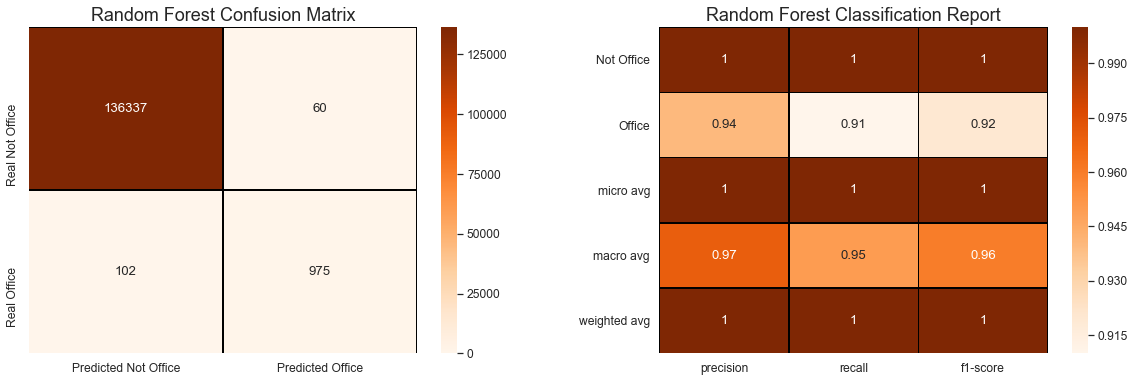

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize = (20,6))
ax1.set_title('Random Forest Confusion Matrix', fontsize = 18)
ax2.set_title('Random Forest Classification Report', fontsize = 18)
plt.subplots_adjust(wspace=0.3)

sns.heatmap(cm_to_df(confusion_matrix(y_test,pred_all)), 
            cmap='Oranges', annot=True, 
            linewidths=0.5,linecolor='black', 
            fmt='g', ax=ax1)
plt.yticks(rotation=90)

sns.heatmap(cr_to_df(classification_report(y_test,pred_all, target_names=['Not Office', 'Office'])).iloc[:,:-1], 
            annot=True, linewidths=0.5, linecolor='black', 
            cmap='Oranges',ax=ax2)
plt.yticks(rotation=0)


In the next step we are going to look at the most important features. Then we are going to re-train the model based on the top 20 most important parameters.

In [16]:
importance = list(zip(data.columns[:-1],rf_all.feature_importances_))
importance.sort(key=lambda x: x[1],reverse=True)

most_important = importance[:20]
most_important = [x for x,y in most_important]
print(most_important)

['officearea', 'landuse_5', 'retailarea', 'comarea', 'resarea', 'builtfar', 'numfloors', 'bldgarea', 'assesstot', 'assessland', 'unitstotal', 'xcoord', 'landuse_8', 'lotarea', 'bldgdepth', 'bldgfront', 'landuse_6', 'landuse_4', 'ycoord', 'lotfront']


The plot below shows the importance of each of these variables.

Text(0.5, 1.0, 'Feature Importance')

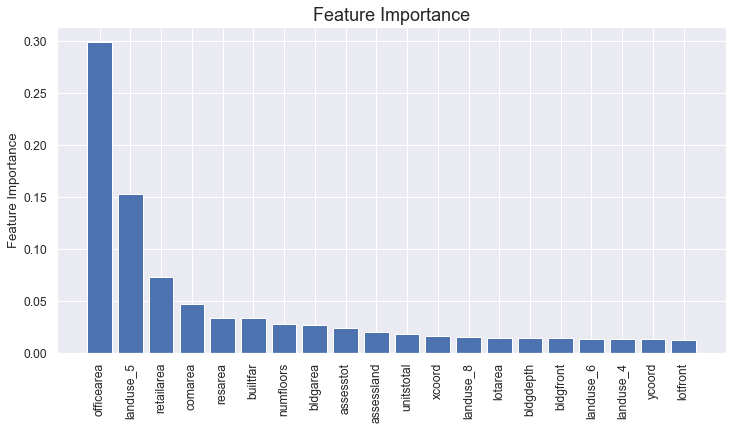

In [17]:
plt.figure(figsize=(12,6))
features = [x for x,y in importance[:20]]
values = [y for x,y in importance[:20]]
x_pos = np.arange(20) 

plt.bar(x_pos, values ,align='center')
plt.xticks(x_pos, features) 
plt.ylabel('Feature Importance')
plt.xticks(rotation=90)
plt.title('Feature Importance', fontsize=18)

In [18]:
X = data[most_important]
y = data.target__office

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
rf = RandomForestClassifier(n_estimators=200, 
                            max_depth=best_parameters['max_depth'], 
                            min_samples_split= best_parameters['min_samples_split']).fit(X_train, y_train)

pred = rf.predict(X_test)

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text yticklabel objects>)

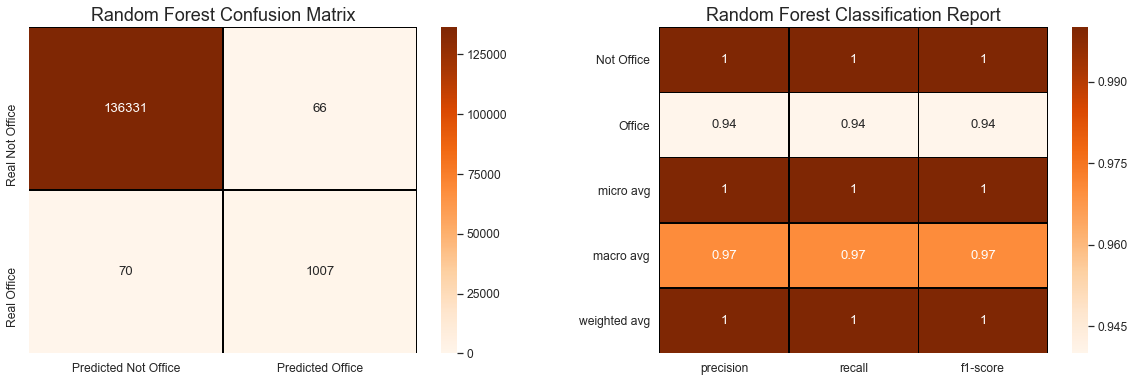

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize = (20,6))
ax1.set_title('Random Forest Confusion Matrix', fontsize = 18)
ax2.set_title('Random Forest Classification Report', fontsize = 18)
plt.subplots_adjust(wspace=0.3)

sns.heatmap(cm_to_df(confusion_matrix(y_test,pred)), 
            cmap='Oranges', annot=True, 
            linewidths=0.5,linecolor='black', 
            fmt='g', ax=ax1)
plt.yticks(rotation=90)

sns.heatmap(cr_to_df(classification_report(y_test,pred, target_names=['Not Office', 'Office'])).iloc[:,:-1], 
            annot=True, linewidths=0.5, linecolor='black', 
            cmap='Oranges',ax=ax2)
plt.yticks(rotation=0)


The results are very good. Our Random Forest model makes very good predictions.

### Predictions on the Test set

Now we are going to use our Random Forest Classifier to make predictions on the test set.
<br>
Following similar steps as before, we preprocess our data with the clean function that we defined.

In [21]:
test_clean = clean(test)
test_clean.head()

,index,borough_BK,borough_QN,borough_MN,borough_SI,borough_BX,fire_com_M,fire_com_L,fire_com_E,fire_com_Q,...,exemptland,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,xcoord,ycoord
0,432027,1,0,0,0,0,0,1,0,0,...,0,0,1931,1,0,0,0,1.94,1008377.0,192685.0
1,97433,0,1,0,0,0,0,1,0,0,...,0,0,1931,0,0,0,0,1.34,1008289.0,218741.0
2,408327,0,1,0,0,0,0,0,1,0,...,1470,1470,1925,0,0,0,0,0.67,1018637.0,196297.0
3,365188,0,1,0,0,0,0,1,0,0,...,0,0,1920,0,0,0,0,0.61,1050330.0,193922.0
4,856787,1,0,0,0,0,0,1,0,0,...,0,0,1899,0,0,0,0,1.72,997418.0,203572.0


Our Classifier accepts the most important features as they have been determined earlier.

In [22]:
test_predict = test_clean[most_important]
display(test_predict.head())

,officearea,landuse_5,retailarea,comarea,resarea,builtfar,numfloors,bldgarea,assesstot,assessland,unitstotal,xcoord,landuse_8,lotarea,bldgdepth,bldgfront,landuse_6,landuse_4,ycoord,lotfront
0,0,0,0,0,3789,1.94,3.0,3789,45962,878,6,1008377.0,0,1958,45.0,19.58,0,0,192685.0,19.58
1,0,0,0,0,3200,1.34,2.0,3200,37203,5700,3,1008289.0,0,2396,64.0,25.00,0,0,218741.0,25.00
2,0,0,0,0,1248,0.67,2.0,1248,24004,8652,1,1018637.0,0,1858,36.0,16.00,0,0,196297.0,18.58
3,0,0,0,0,1648,0.61,2.5,1648,21626,9480,1,1050330.0,0,2700,36.0,16.00,0,0,193922.0,27.00
4,0,0,0,0,1532,1.72,2.0,2298,24616,2846,2,997418.0,0,1333,40.0,16.67,0,0,203572.0,16.67


We make the predictions using the Random Forest Classifier that we defined earlier:

In [23]:
predictions_test = rf.predict(test_predict)
predictions_test = pd.DataFrame(predictions_test,columns=['predicted_office'], index=test_clean.index, dtype=bool)

We concatenate the "predicted_office" column to the Test dataframe:

In [24]:
final = pd.concat([test,predictions_test], axis=1)
display(final.head())

,index,borough,block,lot,schooldist,council,zipcode,firecomp,policeprct,healthcenterdistrict,...,yearalter1,yearalter2,histdist,landmark,builtfar,tract2010,xcoord,ycoord,zonemap,predicted_office
0,432027,BK,3361,34,32.0,37.0,11221.0,L112,83.0,34.0,...,2015,0,NaN,NaN,1.94,435,1008377.0,192685.0,13B,False
1,97433,QN,654,17,30.0,22.0,11103.0,L117,114.0,41.0,...,0,0,NaN,NaN,1.34,143,1008289.0,218741.0,9A,False
2,408327,QN,3811,12,24.0,30.0,11385.0,E319,104.0,46.0,...,0,0,NaN,NaN,0.67,63301,1018637.0,196297.0,13D,False
3,365188,QN,10988,17,29.0,27.0,11412.0,L150,113.0,44.0,...,0,0,NaN,NaN,0.61,526,1050330.0,193922.0,15B,False
4,856787,BK,2619,36,14.0,33.0,11222.0,L106,94.0,30.0,...,0,0,NaN,NaN,1.72,561,997418.0,203572.0,13A,False


We can plot our results from the Train dataset and the Predicted Test data set by coordinates and classification.

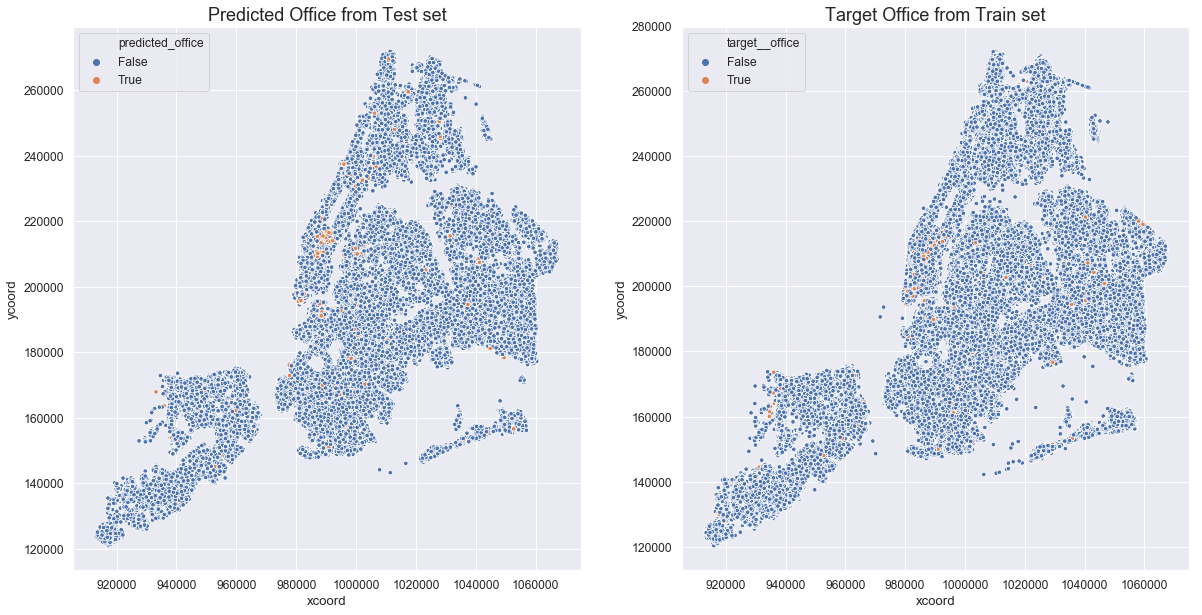

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize = (20,10))
ax1.set_title('Predicted Office from Test set', fontsize = 18)
ax2.set_title('Target Office from Train set', fontsize = 18)

sns.scatterplot(x='xcoord', y='ycoord', data=final, hue='predicted_office', s=20, ax=ax1)
sns.scatterplot(x='xcoord', y='ycoord', data=train_clean, hue='target__office', s=20, ax=ax2)

Observing the plots above and using our intuition we can see a higher concentration of office buildings in the main business areas of New York (Midtown, Financial District, Downtown Brooklyn, Court Square) which makes sense.

Text(0.5, 1.0, 'Feature Importance')

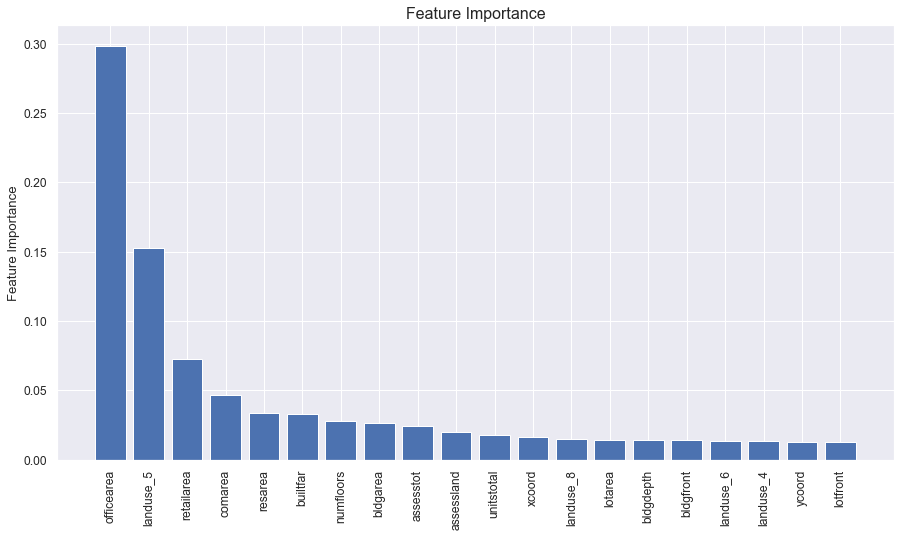

In [26]:
plt.figure(figsize=(15,8))
features = [x for x,y in importance[:20]]
values = [y for x,y in importance[:20]]
x_pos = np.arange(20) 

plt.bar(x_pos, values ,align='center')
plt.xticks(x_pos, features) 
plt.ylabel('Feature Importance')
plt.xticks(rotation=90)
plt.title('Feature Importance', fontsize=16)

From the above plot we can see that the "office area" variable is the most important in determining the category of each datapoint.
<br>
<br>
Finally, we save the csv file as "test_predicted.csv":

In [27]:
final.to_csv('test_predicted.csv', index=False)

### Conclusion and Comments

A large portion of the work focused around preprocessing of the data. Given the description of each variable different techniques have been applied. The resulting dataset led to an excellent performance of the Classifier.
<br>
<br>
As mentioned earlier, the dataset was imbalanced, something that presents additional challenges. Oversampling and undersampling could also have been applied to address the class distribution.
<br>
<br>
Additional classification models that could have been used are the Gradient Boosting Classifier, K-Nearest Neighbors and Support Vector Machine (in a trial Gradient Boosting Decision Tree model the performance was slightly worse than the Random Forest model). However due to the performance of the Random Forest and the limited computational power, they did not deem necessary.